# Tree Based Models

Objectives:
1.  Visualize the iris dataset
2.  Build decision trees to fit the iris dataset
3.  Visualize decision trees
4.  Build a random forest and an Adaboost model to fit the iris dataset

In [ ]:
!pip install plotly==5.5.0

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

## The iris Dataset

We will use the iris dataset for this hands-on session.

The iris dataset consists of 3 different types of irises' (Setosa, Versicolour, and Virginica) petal and sepal length. There are 50 instances for each class.

![](Figs/iris-machinelearning.png)

In [ ]:
# We load the iris dataset
df = px.data.iris()
x_all = df[["sepal_length","sepal_width", "petal_length", "petal_width"]].to_numpy()
y_all = df["species_id"].to_numpy()-1
df

In [ ]:
fig = px.scatter_3d(df, x='sepal_length', y='petal_length', z='petal_width',
              color='species', opacity=0.7)
fig.update_layout(width=800, height=600)
fig.show()

## Decision Trees

We will build decision trees by calling build-in methods in the sklearn package.

In [ ]:
# First we do a train-test split.

from sklearn.model_selection import train_test_split
id_all = np.arange(len(df))
x, x_test, y, y_test, id_train, id_test = train_test_split(x_all,y_all,id_all, test_size=0.33, random_state=10)

In [ ]:
# We also split the dataframe accordingly for later illustrations.

df_train = df.iloc[id_train]
df_test = df.iloc[id_test]

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# First we fit a shallow tree.
TreeClassifier = DecisionTreeClassifier(criterion="entropy", max_depth=2, random_state=15)
clf = TreeClassifier.fit(x,y)

In [ ]:
# A simple decision tree can be easily visualized.

from sklearn.tree import plot_tree
plt.figure(figsize=(14, 10))
plot_tree(clf, filled=True,
          feature_names=["sepal_length","sepal_width", "petal_length", "petal_width"],
          class_names=["Setosa", "Versicolour", "Virginica"])
plt.show()

In [156]:
# We know that a decision tree make splittings on feature variables to make predictions.
# Let us visualize how the feature space is divided.

fig = px.scatter_3d(df_train, x='sepal_length', z='petal_length', y='petal_width',
                    opacity=0.7, color='species',
                    color_discrete_map={
                         "setosa": "orange",
                         "versicolor": "green",
                         "virginica": "purple"}
                    )
fig.update_traces(marker_size=5)
X = [df['sepal_length'].min(), df['sepal_length'].max()]
Y = [df['petal_width'].min(), df['petal_width'].max()]
Z = [[2.45, 2.45],
     [2.45, 2.45]]
fig.add_trace(go.Surface(x=X,y=Y,z=Z, opacity=0.2, showscale=False))
Z2 = [[4.75, 4.75],
     [4.75, 4.75]]
fig.add_trace(go.Surface(x=X,y=Y,z=Z2, opacity=0.2, showscale=False))
fig.update_layout(width=800, height=600)
fig.show()

In [157]:
# Let us also visualize on the test dataset.

fig = px.scatter_3d(df_test, x='sepal_length', z='petal_length', y='petal_width',
                    opacity=0.7, color='species',
                    color_discrete_map={
                         "setosa": "orange",
                         "versicolor": "green",
                         "virginica": "purple"}
                    )
fig.update_traces(marker_size=5)
X = [df['sepal_length'].min(), df['sepal_length'].max()]
Y = [df['petal_width'].min(), df['petal_width'].max()]
Z = [[2.45, 2.45],
     [2.45, 2.45]]
fig.add_trace(go.Surface(x=X,y=Y,z=Z, opacity=0.2, showscale=False))
Z2 = [[4.75, 4.75],
     [4.75, 4.75]]
fig.add_trace(go.Surface(x=X,y=Y,z=Z2, opacity=0.2, showscale=False))
fig.update_layout(width=800, height=600)
fig.show()

In [158]:
# Let us test performence on test set.

y_test_pred = clf.predict(x_test)
print((y_test==y_test_pred).sum()/len(y_test))

0.92


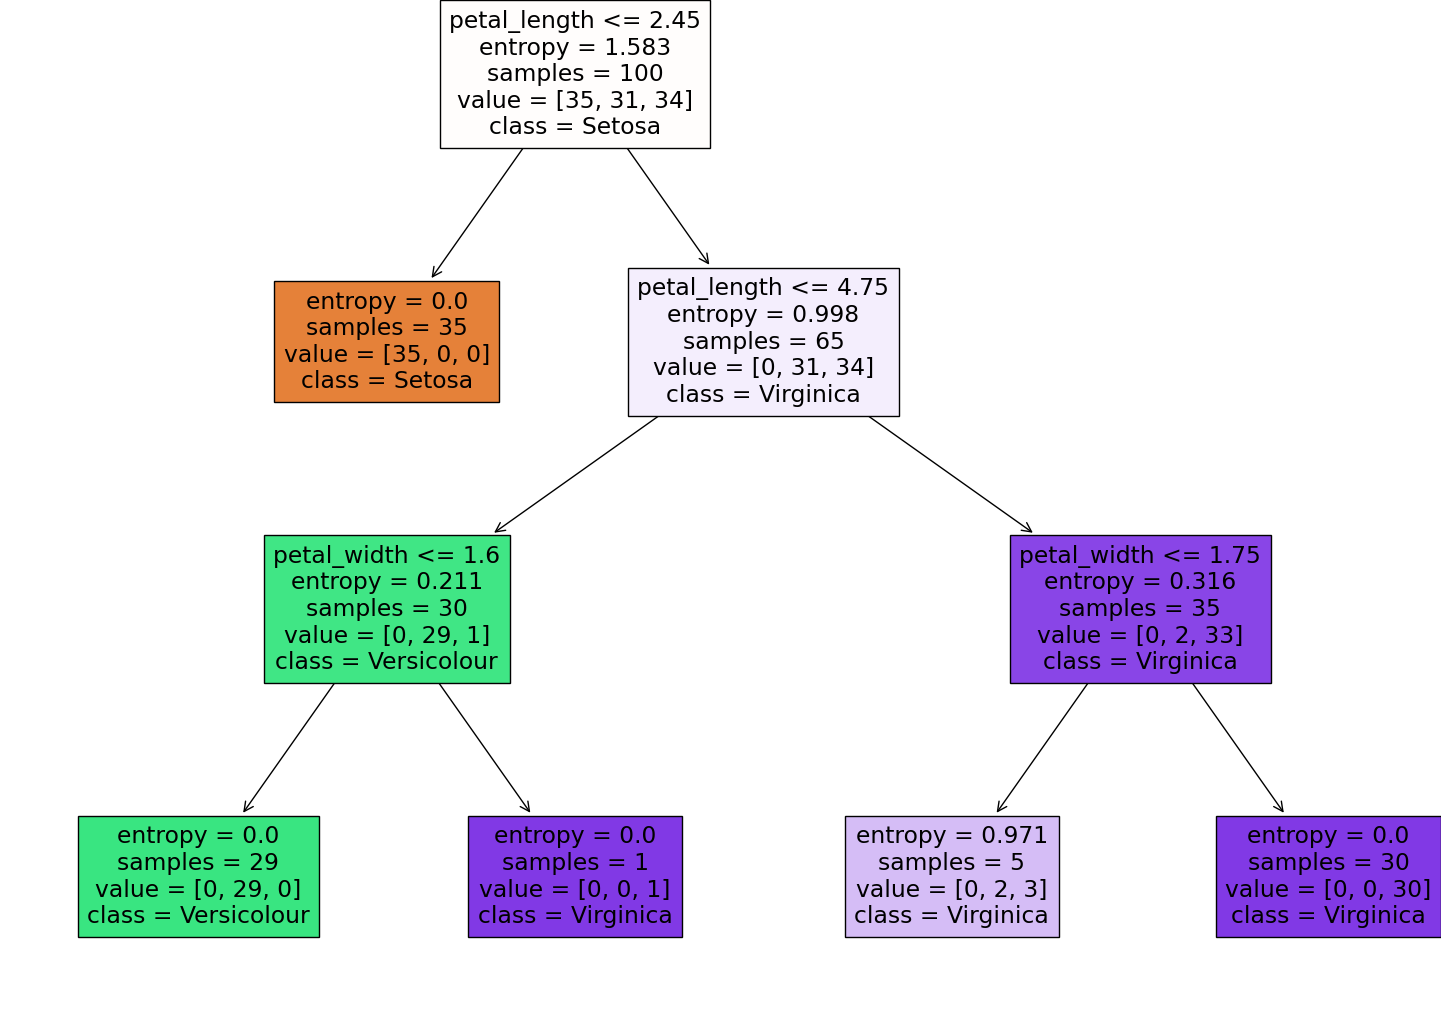

In [159]:
# Now we fit a deeper tree.
TreeClassifier = DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf_deep = TreeClassifier.fit(x,y)

plt.figure(figsize=(14, 10))
plot_tree(clf_deep, filled=True,
          feature_names=["sepal_length","sepal_width", "petal_length", "petal_width"],
          class_names=["Setosa", "Versicolour", "Virginica"])
plt.show()

In [160]:
# Let us test performence on test set.

y_test_pred = clf_deep.predict(x_test)
print((y_test==y_test_pred).sum()/len(y_test))

0.92


## Random Forest

We see that a single decision tree can achieve $92\%$ accuracy on our test dataset. Increasing the tree size can fit the training data perfectly, but performance on test dataset may drop, which indicates overfitting.

In this section, we test performance of a random forest model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

ForestClassifier =RandomForestClassifier(
    n_estimators=10,
    n_jobs=-1, # Use all CPU cores to fit trees
    max_samples = 0.8,
    criterion='entropy'
)
rfc = ForestClassifier.fit(x,y)

A random forest model contain many decision trees, and the final prediction is based on majority voting. This makes visualization very difficult. One way is to just visualize individual trees in the forest.

In [ ]:
trees = rfc.estimators_
tree1 = trees[0]
plt.figure(figsize=(14, 10))
plot_tree(tree1, filled=True,
          feature_names=["sepal_length","sepal_width", "petal_length", "petal_width"],
          class_names=["Setosa", "Versicolour", "Virginica"])
plt.show()

In [ ]:
y_test_pred = rfc.predict(x_test)
print((y_test==y_test_pred).sum()/len(y_test))

Please tune the parameters in the random forest model to see how it affects the model performance.

## AdaBoost

Lastly let us try the AdaBoost method. Fitting the model is almost identical to fitting a random forest.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

BoostClassifier = AdaBoostClassifier(n_estimators=50)
abc = BoostClassifier.fit(x,y)

Because the trees in AdaBoost have different roles, we cannot visualize individual trees. Let us test model performance directly.

In [ ]:
y_test_pred = abc.predict(x_test)
print((y_test==y_test_pred).sum()/len(y_test))

We do not see performance difference between random forest and AdaBoost. This is because our dataset is small and easy. You can try these two methods on more complicated dataset!